# Bitcoin Transaction Fee Spike Detection

This notebook builds a pipeline to detect upcoming spikes in Bitcoin transaction fees using:
- **Supervised classification (XGBoost)**
- **Rolling window evaluation**
- **Unsupervised baselines (Isolation Forest, Prophet)**

### Objective
Instead of forecasting exact transaction fee values, we predict **whether a fee spike (over 5 sats/vByte) will occur within the next 24 hours**.


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [60]:
# Load & preprocess data
series_full = pd.read_parquet("../data/processed/preprocessed_prophet.parquet")
series_full.index = pd.to_datetime(series_full.index)
series_full = series_full.sort_index()

# Label spikes (target = will fee exceed 5 in next 24h)
horizon = 288  # 24 hours for 5-min data
threshold = 3
series_full["target"] = (series_full["recommended_fee_fastestFee"].shift(-horizon) > threshold).astype(int)

In [61]:
# Lag features
lags = [1, 3, 6, 12, 24, 48, 96, 144, 288]
for lag in lags:
    series_full[f"lag_{lag}"] = series_full["recommended_fee_fastestFee"].shift(lag)

# Exogenous features
exog_cols = [col for col in series_full.columns if col.startswith("mempool") or "block" in col]

# Clean data
df = series_full.dropna().copy()
features = [f"lag_{lag}" for lag in lags] + exog_cols

In [62]:
split_point = int(len(df) * 0.8)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

In [63]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0)
param_grid = {
    "max_depth": [3, 5],
    "n_estimators": [50, 100],
    "learning_rate": [0.05, 0.1]
}
gs = GridSearchCV(xgb, param_grid, cv=3)
gs.fit(train[features], train["target"])
y_pred = gs.predict(test[features])
print(classification_report(test["target"], y_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       884
           1       0.31      0.36      0.33       379

    accuracy                           0.56      1263
   macro avg       0.50      0.51      0.50      1263
weighted avg       0.58      0.56      0.57      1263



In [ ]:
# rolling_preds = []
window = 2016
step = 144

# for start in range(0, len(df) - window - horizon, step):
#     roll_train = test.iloc[start : start + window]
#     roll_test = test.iloc[start + window : start + window + horizon]
#     model = gs.best_estimator_
#     model.fit(roll_train[features], roll_train["target"])
#     preds = model.predict(roll_test[features])
#     rolling_preds.append((roll_test.index, roll_test["target"].values, preds))
rolling_preds_xgb = []

for start in range(0, len(df) - window - horizon, step):
    roll_train = df.iloc[start : start + window].dropna().copy()
    roll_test = df.iloc[start + window : start + window + horizon].dropna().copy()

    # Ensure valid target and no NaNs
    roll_train["target"] = roll_train["target"].astype(int)
    if roll_train["target"].nunique() < 2:
        continue

    model = gs.best_estimator_
    model.fit(roll_train[features], roll_train["target"])
    preds = model.predict(roll_test[features])
    rolling_preds_xgb.append((roll_test.index, roll_test["target"].values, preds))

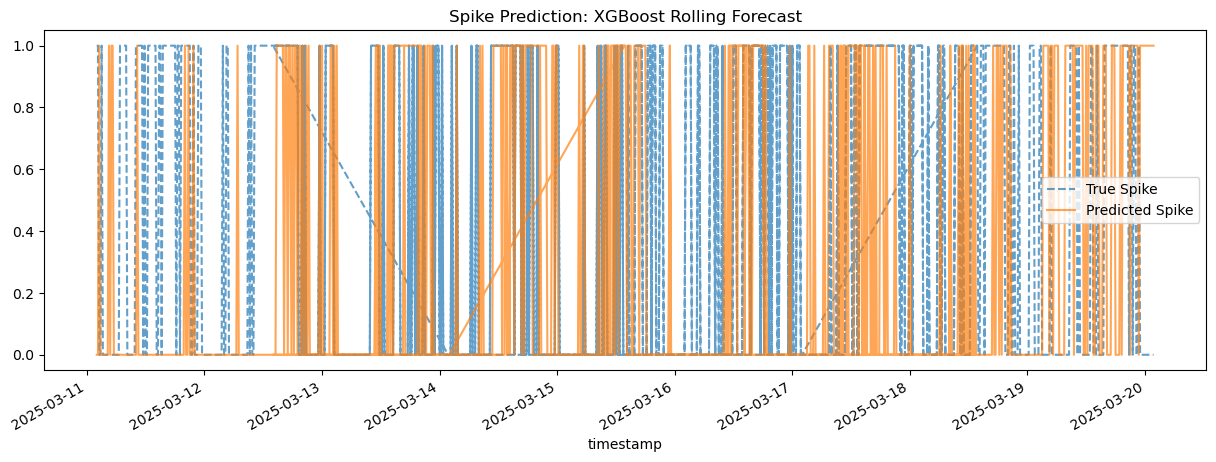

In [70]:
all_preds = pd.DataFrame({
    "timestamp": np.concatenate([i[0] for i in rolling_preds_xgb]),
    "true": np.concatenate([i[1] for i in rolling_preds_xgb]),
    "pred": np.concatenate([i[2] for i in rolling_preds_xgb])
}).set_index("timestamp")

plt.figure(figsize=(15, 5))
all_preds["true"].plot(label="True Spike", style="--", alpha=0.7)
all_preds["pred"].plot(label="Predicted Spike", alpha=0.7)
plt.legend()
plt.title("Spike Prediction: XGBoost Rolling Forecast")
plt.show()

In [65]:
iso = IsolationForest(contamination=0.05)
iso.fit(train[features])
isolation_preds = iso.predict(test[features])
test['iso_flag'] = (isolation_preds == -1).astype(int)

In [51]:
prophet_df = df[["recommended_fee_fastestFee"]].reset_index().rename(columns={"timestamp": "ds", "recommended_fee_fastestFee": "y"})
prophet_df = prophet_df.resample("5min", on="ds").mean().interpolate()
prophet_df = prophet_df.reset_index() 

In [57]:
prophet = Prophet()
prophet.fit(prophet_df[:-horizon])
future = prophet.make_future_dataframe(periods=horizon, freq="5min")
forecast = prophet.predict(future)
forecast['spike_flag'] = (forecast['yhat'] > 5).astype(int)

10:40:43 - cmdstanpy - INFO - Chain [1] start processing
10:40:46 - cmdstanpy - INFO - Chain [1] done processing


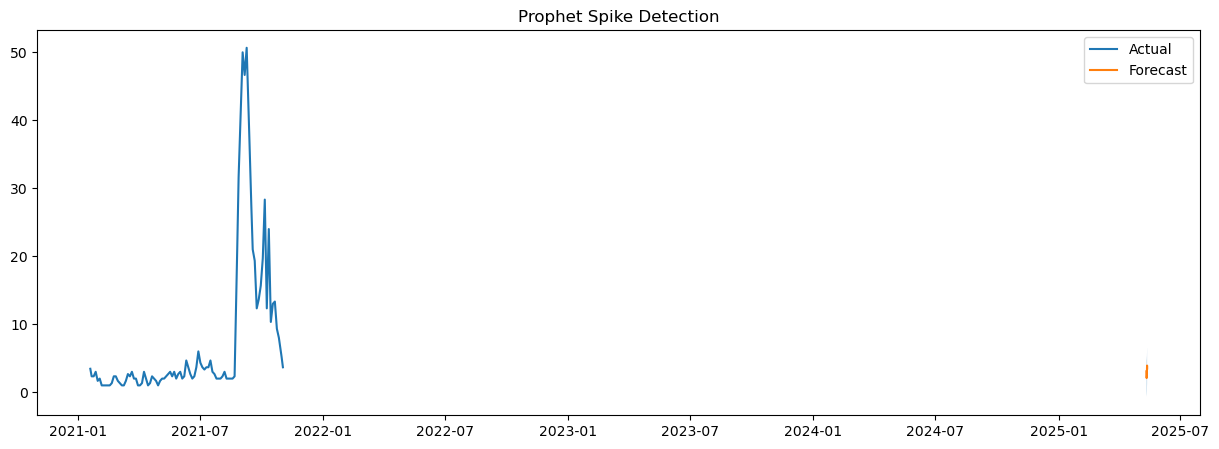

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(prophet_df.index[-horizon:], prophet_df.y[-horizon:], label="Actual")
plt.plot(forecast.ds[-horizon:], forecast.yhat[-horizon:], label="Forecast")
plt.fill_between(forecast.ds[-horizon:], forecast.yhat_lower[-horizon:], forecast.yhat_upper[-horizon:], alpha=0.3)
plt.title("Prophet Spike Detection")
plt.legend()
plt.show()

In [53]:
summary_log = pd.DataFrame({
    "model": ["XGBoost", "IsolationForest", "Prophet"],
    "description": [
        "Supervised classifier on engineered + exogenous features",
        "Unsupervised anomaly detection",
        "Forecasting baseline for anomaly based on prediction interval"
    ]
})
print(summary_log)

             model                                        description
0          XGBoost  Supervised classifier on engineered + exogenou...
1  IsolationForest                     Unsupervised anomaly detection
2          Prophet  Forecasting baseline for anomaly based on pred...


In [59]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from prophet import Prophet
import matplotlib.pyplot as plt

# ----------------------------
# Load and preprocess data
# ----------------------------
df = pd.read_parquet("../data/processed/preprocessed_prophet.parquet")
df = df.sort_index()
df["target"] = (df["recommended_fee_fastestFee"].shift(-288) > 5).astype(int)

# Create lagged features
lags = [1, 3, 6, 12, 24, 48, 96, 144, 288]
for lag in lags:
    df[f"lag_{lag}"] = df["recommended_fee_fastestFee"].shift(lag)

# Use exogenous features
exog_cols = [col for col in df.columns if col.startswith("mempool") or "block" in col]
features = [f"lag_{lag}" for lag in lags] + exog_cols

df = df.dropna()

# ----------------------------
# Rolling setup
# ----------------------------
window = 2016  # 7 days
horizon = 288  # 1 day
step = 144     # move every 12 hours

results = []

for start in range(0, len(df) - window - horizon, step):
    roll_train = df.iloc[start:start+window]
    roll_test = df.iloc[start+window:start+window+horizon]
    
    # -- XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    xgb.fit(roll_train[features], roll_train["target"])
    xgb_preds = xgb.predict(roll_test[features])
    
    # -- Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(roll_train[features])
    iso_preds = iso.predict(roll_test[features])
    iso_preds = (iso_preds == -1).astype(int)  # convert to 1 if anomaly
    
    # -- Prophet
    prophet_df = roll_train[["recommended_fee_fastestFee"]].reset_index()
    prophet_df.columns = ["ds", "y"]
    p = Prophet()
    p.fit(prophet_df)
    future = p.make_future_dataframe(periods=horizon, freq="5min")
    forecast = p.predict(future)
    yhat = forecast["yhat"].iloc[-horizon:].values
    actual = roll_test["recommended_fee_fastestFee"].values
    prophet_preds = (actual > forecast["yhat_upper"].iloc[-horizon:].values).astype(int)
    
    # True values
    y_true = roll_test["target"].values
    
    # Collect results
    for model_name, preds in zip(
        ["XGBoost", "IsolationForest", "Prophet"],
        [xgb_preds, iso_preds, prophet_preds]
    ):
        results.append({
            "model": model_name,
            "window_end": roll_train.index[-1],
            "precision": precision_score(y_true, preds, zero_division=0),
            "recall": recall_score(y_true, preds, zero_division=0),
            "f1": f1_score(y_true, preds, zero_division=0),
        })

# ----------------------------
# Summary table
# ----------------------------
results_df = pd.DataFrame(results)
summary = results_df.groupby("model")[["precision", "recall", "f1"]].mean().round(3)
print(summary)


11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:10 - cmdstanpy - INFO - Chain [1] start processing
11:55:10 - cmdstanpy - INFO - Chain [1] done processing
11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:13 - cmdstanpy - INFO - Chain [1] start processing
11:55:13 - cmdstanpy - INFO - Chain [1] done processing
11:55:13 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1]

                 precision  recall     f1
model                                    
IsolationForest      0.055   0.059  0.039
Prophet              0.125   0.120  0.089
XGBoost              0.072   0.054  0.024
